# Information System: Supply Chain Management

## User Stories and Respective Queries

In [1]:
#Importing Libraries

In [128]:
import redis
import pandas as pd
from pandas import DataFrame
import json
import re 
from pymongo import MongoClient
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
from geopy.distance import geodesic 

In [4]:
client=MongoClient('localhost',27017)
db=client['SCM']

In [5]:
redisClient = redis.Redis("localhost", 6379)

In [21]:
driver=GraphDatabase.driver(uri="bolt://localhost:7687",auth=("neo4j","123"))

## User Story: Manufacturer wants to know which city has the highest number of customers and distributors so that he can set up warehouse in the demanding region


In [143]:
result_HighDist=db.SCM_Distributor_dataset.aggregate([{'$group':{'_id':"$Distributor_city",'CountOfDistIds':{'$sum': 1},},},{'$sort':{'CountOfDistIds':-1}},{'$limit': 10},])
result_HighCust=db.SCM_customer_dataset.aggregate([{'$group':{'_id':"$customer_city",'CountOfCustmrIds':{'$sum': 1},},},{'$sort':{'CountOfCustmrIds':-1}},{'$limit': 10},])

In [144]:
result_HighDist_df=pd.DataFrame(list(result_HighDist))
result_HighCust_df=pd.DataFrame(list(result_HighCust))

In [139]:
 result_HighDist_df

,CountOfDistIds,_id
0,694,sao paulo
1,127,curitiba
2,96,rio de janeiro
3,68,belo horizonte
4,52,ribeirao preto
5,50,guarulhos
6,49,ibitinga
7,45,santo andre
8,41,campinas
9,40,maringa


In [140]:
result_HighCust_df

,CountOfCustmrIds,_id
0,15540,sao paulo
1,6882,rio de janeiro
2,2773,belo horizonte
3,2131,brasilia
4,1521,curitiba
5,1444,campinas
6,1379,porto alegre
7,1245,salvador
8,1189,guarulhos
9,938,sao bernardo do campo


In [148]:
# Merge the Two DataFrames to Combine on Basics of City

CustDistStats=result_HighCust_df.merge(result_HighDist_df, on='_id', how = 'outer')
CustDistStats

,CountOfCustmrIds,_id,CountOfDistIds
0,15540.0,sao paulo,694.0
1,6882.0,rio de janeiro,96.0
2,2773.0,belo horizonte,68.0
3,2131.0,brasilia,NaN
4,1521.0,curitiba,127.0
5,1444.0,campinas,41.0
6,1379.0,porto alegre,NaN
7,1245.0,salvador,NaN
8,1189.0,guarulhos,50.0
9,938.0,sao bernardo do campo,NaN


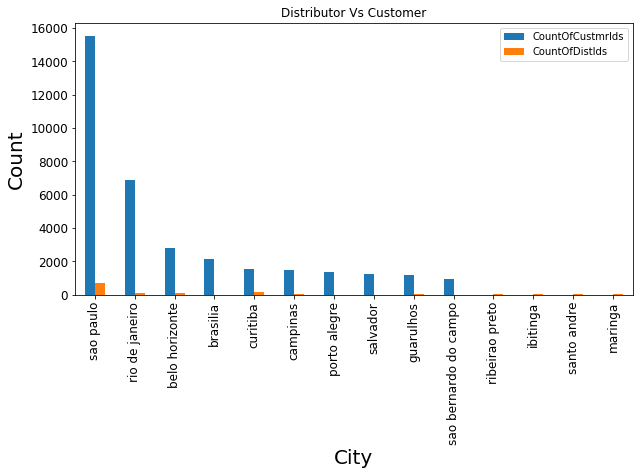

In [150]:
#ax =CustDistStats.plot.bar(rot=0)
ax =CustDistStats.plot(kind='bar', title ="Distributor Vs Customer", figsize=(10, 5), legend=True, fontsize=12)
ax.set_xticklabels(CustDistStats['_id'])
ax.set_xlabel("City", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.show()

## User Story:Manufacturer wants to know which distributor has sold which product the most so that he can manage the supply as per the demand


In [209]:
Distributor_Product=db.SCM_order_items_dataset.find({},{'Distributor_id':1,'product_id':1,'_id':0})

In [210]:
df=pd.DataFrame(list(Distributor_Product))

In [211]:
#Add a new Column For Size

df['Count']=df.groupby(['Distributor_id','product_id'])['Distributor_id'].transform('size')

In [212]:
df=df.sort_values(by='Count', ascending=False)

In [213]:
df=df.drop_duplicates(subset ='Distributor_id')

In [214]:
df

,Distributor_id,product_id,Count
102567,4a3ca9315b744ce9f8e9374361493884,Samsung-106,31
70316,6560211a19b47992c3666cc44a7e94c0,Samsung-073,28
4705,1f50f920176fa81dab994f9023523100,Samsung-005,28
71791,cc419e0650a3c5ba77189a1882b7556a,Samsung-074,25
44057,da8622b14eb17ae2831f4ac5b9dab84a,Samsung-046,25
17190,955fee9216a65b617aa5c0531780ce60,Samsung-018,22
23443,1025f0e2d44d7041d6cf58b6550e0bfa,Samsung-025,22
16691,7a67c85e85bb2ce8582c35f2203ad736,Samsung-018,21
85519,7c67e1448b00f6e969d365cea6b010ab,Samsung-089,21
22168,3d871de0142ce09b7081e2b9d1733cb1,Samsung-023,19


## User Story: Customer Care Executive wants to get customer details along with the distributor details to make on-call assitance more convenient to have enhanced customer experience

In [296]:
#Input Customer ID

Input_Customer_id="9805434ec0ad1e8f656a4a7b3fdda315"

In [297]:
Customer_details=db.SCM_order_items_dataset.aggregate([
{
    '$match': {'customer_id': Input_Customer_id}
},
{
   '$lookup':
    {
    'from': "SCM_Distributor_dataset",
    'localField': "Distributor_id",
    'foreignField': "Distributor_id",
    'as': "Distributor_Details"
    }
},

{
   '$lookup':
    {
    'from': "SCM_customer_dataset",
    'localField': "customer_id",
    'foreignField': "customer_id",
    'as': "Customer_Details"
    }
},

{'$project':{'order_id':1, 'Distributor_id':1, 'product_id':1,'_id':0, 'Customer_Details':1,'Distributor_Details':1}}
])

In [298]:
Customer_details_df=pd.DataFrame(list(Customer_details))

In [299]:
Customer_details_df

,Customer_Details,Distributor_Details,Distributor_id,order_id,product_id
0,"[{'_id': 5e5654f6848fdceb375bce7c, 'customer_i...","[{'_id': 5e53fbe9ea271aaed90e5693, 'Distributo...",955fee9216a65b617aa5c0531780ce60,52c41e4882172d2311d038615bf36d46,Samsung-001
1,"[{'_id': 5e5654f6848fdceb375bce7c, 'customer_i...","[{'_id': 5e53fbe9ea271aaed90e5693, 'Distributo...",955fee9216a65b617aa5c0531780ce60,52c41e4882172d2311d038615bf36d46,Samsung-051


## User Story: Consumer wants to search the products with a particular configuration of RAM, ROM, Chipset, HeadphoneJack within a particular battery capacity range and price range

In [37]:
getproductsofparticularConfig="match (p:Prod)-[h1:has_ram]->(r:ram{Ram:'6 GB RAM'}),(p:Prod)-[h2:has_rom]->(R:rom{Rom:'128 GB ROM'}), (p:Prod)-[h3:has_chipset]->(c:chipset{Chip:'Qualcomm'}), (p:Prod)-[h4:has_headphonejack]->(h:headphone{HeadphoneJack:'Yes'}) where '2000 mAh' <= p.ProductBattery <= '4500 mAh' and '20000' <= p.ProductPrice <= '25000' return p.ProductModel as Product, r.Ram as RAM, R.Rom as ROM, c.Chip as Chipset, h.HeadphoneJack as HeadsetJack"

In [38]:
with driver.session() as graphDB_Session:
    result = graphDB_Session.run(getproductsofparticularConfig)
    df_Configuation = DataFrame(result.records(), columns=result.keys())

In [39]:
df_Configuation

,Product,RAM,ROM,Chipset,HeadsetJack
0,Galaxy A60,6 GB RAM,128 GB ROM,Qualcomm,Yes
1,Galaxy A6s,6 GB RAM,128 GB ROM,Qualcomm,Yes


## User Story:Manufacturer wants to know the outdated product models still available in the inventory and wants to plan year-wise discounts so as to clear the existing stocks

In [40]:
outdated_products="match (p) where p.ProductLaunchYear <='2016' return toInteger(p.ProductLaunchYear) as ProductLaunchYear, count(p.ProductLaunchYear) as ProductCount, collect(p.ProductModel) as ProductModel, collect(toInteger(p.ProductPrice)) as Price, collect(toInteger(p.ProductPrice) - ((2017-toInteger(p.ProductLaunchYear))*500)) as DiscountedPrice"

In [41]:
with driver.session() as graphDB_Session:
    result1 = graphDB_Session.run(outdated_products)
    df_outdated_products = DataFrame(result1.records(), columns=result1.keys())

In [42]:
df_outdated_products

,ProductLaunchYear,ProductCount,ProductModel,Price,DiscountedPrice
0,2016,20,"[Galaxy A8 (2016), Galaxy On8, Galaxy On7 (201...","[39000, 10999, 16990, 14500, 12500, 6200, 5990...","[38500, 10499, 16490, 14000, 12000, 5700, 5940..."
1,2015,17,"[Galaxy A9 (2016), Galaxy A7 (2016), Galaxy A5...","[31999, 17900, 19990, 8490, 32000, 22540, 2399...","[30999, 16900, 18990, 7490, 31000, 21540, 2299..."
2,2014,11,"[Galaxy Core Prime, Galaxy A5 Duos, Galaxy A5,...","[7990, 11900, 11900, 8999, 8190, 21999, 7900, ...","[6490, 10400, 10400, 7499, 6690, 20499, 6400, ..."
3,2013,9,"[Galaxy J, Galaxy Note 3, I9506 Galaxy S4, Gal...","[13290, 22900, 19899, 22500, 10999, 15699, 109...","[11290, 20900, 17899, 20500, 8999, 13699, 8999..."
4,2012,7,"[Galaxy Victory 4G LTE L300, Galaxy Camera GC1...","[4599, 5800, 4250, 5900, 5500, 5300, 8000]","[2099, 3300, 1750, 3400, 3000, 2800, 5500]"
5,2011,15,"[I9103 Galaxy R, I929 Galaxy S II Duos, Galaxy...","[4599, 6499, 5899, 7850, 6000, 7500, 5499, 599...","[1599, 3499, 2899, 4850, 3000, 4500, 2499, 299..."
6,2010,5,"[Google Nexus S, Mesmerize i500, Vibrant, i897...","[7999, 6590, 7500, 6999, 6499]","[4499, 3090, 4000, 3499, 2999]"


## User Story:When a consumer searches for a particular product, the seller wants to recommend other products with similar configuration to the consumer so that customer can have other available product options 


In [293]:
#Input Product Model
ProductModel= "Galaxy S8 Active"
recommended_sets="match (p1) where p1.ProductModel = '"+ProductModel+"'match(p1{ProductModel:'"+ProductModel+"'})-[:has_ram]->(r)<-[:has_ram]-(p2) match(p1{ProductModel:'"+ProductModel+"'})-[:has_rom]->(R)<-[:has_rom]-(p2) match(p1{ProductModel:'"+ProductModel+"'})-[:has_chipset]->(c)<-[:has_chipset]-(p2) match(p1)-[h4:has_headphonejack]->(h) match (p2) where toInteger(p2.ProductPrice) < toInteger(p1.ProductPrice) and p1 <> p2 with p1, p2, r, R, c, h order by p2.ProductPrice return  p1.ProductID as ProductID, p1.ProductModel as ProductModel, toInteger(p1.ProductLaunchYear) as ProductLaunchYear,  r.Ram as RAM, R.Rom as ROM, c.Chip as Chipset, h.HeadphoneJack as HeadsetJack, p1.ProductBattery as Battery, toInteger(p1.ProductPrice) as Price, collect(p2.ProductModel) as  RecomendedModels, collect(toInteger(p2.ProductPrice)) as ModelPrice"
#recommended_sets="match (p1:Prod) where p1.ProductModel = 'Galaxy S6 Duos' match(p1:Prod{ProductModel:'Galaxy S6 Duos'})-[:has_ram]->(r)<-[:has_ram]-(p) match(p1:Prod{ProductModel:'Galaxy S6 Duos'})-[:has_rom]->(R)<-[:has_rom]-(p) match(p1:Prod{ProductModel:'Galaxy S6 Duos'})-[:has_chipset]->(c)<-[:has_chipset]-(p) match(p1:Prod)-[h4:has_headphonejack]->(h) match (p:Prod) where toInteger(p1.ProductPrice) - 3000 < toInteger(p.ProductPrice) < toInteger(p1.ProductPrice) + 3000 and p1 <> p return  p1.ProductID as ProductID, p1.ProductModel as ProductModel, toInteger(p1.ProductLaunchYear) as ProductLaunchYear,  r.Ram as RAM, R.Rom as ROM, c.Chip as Chipset, h.HeadphoneJack as HeadsetJack, p1.ProductBattery as Battery, toInteger(p1.ProductPrice) as Price, collect(p.ProductModel) as  RecomendedModels, collect(toInteger(p.ProductPrice)) as ModelPrice"

In [294]:
with driver.session() as graphDB_Session:
    result2= graphDB_Session.run(recommended_sets)
    df_recommendedSets=DataFrame(result2.records(), columns=result2.keys())

In [295]:
df_recommendedSets

,ProductID,ProductModel,ProductLaunchYear,RAM,ROM,Chipset,HeadsetJack,Battery,Price,RecomendedModels,ModelPrice
0,Samsung-043,Galaxy S8 Active,2017,4 GB RAM,64 GB ROM,Qualcomm,Yes,4000 mAh,54000,"[Galaxy J6+, Galaxy J8, Galaxy A6+ (2018), Gal...","[11999, 15499, 15800, 24200, 26600]"


## User Story:As a customer I want to track my order status 

In [261]:
# Input Order_id
order_id="ad21c59c0840e6cb83a9ceb5573f8159"

In [262]:
x1=redisClient.hscan(order_id, match="order_status*")
x1=x1[1]

In [263]:
order_status_ = { y.decode('ascii'): x1.get(y).decode('ascii') for y in x1.keys() }
order_status_

{'order_status': 'delivered'}

## User Story:Based on the order status, delivery Agent wants to update the order status, so that customer is well informed about his order.

In [278]:
#Input the Status
New_Status="Returned"
order_id="ad21c59c0840e6cb83a9ceb5573f8159"

In [279]:
kw = {'order_status': New_Status}
redisClient.hmset(order_id, kw)
x1=redisClient.hscan(order_id, match="order_status*")
x1=x1[1]
order_status_ = { y.decode('ascii'): x1.get(y).decode('ascii') for y in x1.keys() }
order_status_

{'order_status': 'Returned'}

## User Story:For all the generated orders for the day Logistic Manager wants to know the distance between customer and distributor so that he can plan for the better transportaion medium(Airways and Roadways)

In [280]:
#Input Orderid
order_id="5f12df808d35ea25be28ad052f4aa3ea"

In [281]:
Order_location_details=db.SCM_order_items_dataset.aggregate([
{
    '$match': {'order_id': order_id}
},
{
   '$lookup':
    {
    'from': "SCM_Distributor_dataset",
    'localField': "Distributor_id",
    'foreignField': "Distributor_id",
    'as': "Distributor_Details"
    }
},
{'$unwind':"$Distributor_Details"},
{
   '$lookup':
    {
    'from': "SCM_customer_dataset",
    'localField': "customer_id",
    'foreignField': "customer_id",
    'as': "Customer_Details"
    }
},
{'$unwind':"$Customer_Details"},
{'$project':{'order_id':1, 'Distributor_id':1, 'product_id':1,'_id':0, "Customer_Details.customer_zip_code_prefix":1,"Distributor_Details.Distributor_zip_code_prefix":1}}
])
Order_location_details_df=pd.DataFrame(Order_location_details)

In [282]:
Order_location_details_df

,Customer_Details,Distributor_Details,Distributor_id,order_id,product_id
0,{'customer_zip_code_prefix': 13080},{'Distributor_zip_code_prefix': 9628},f7ba60f8c3f99e7ee4042fdef03b70c4,5f12df808d35ea25be28ad052f4aa3ea,Samsung-001


In [283]:
#Converting Dictionary to String
Customer_PinCode=json.dumps(Order_location_details_df.iloc[0]['Customer_Details'])

Distributor_PinCode=json.dumps(Order_location_details_df.iloc[0]['Distributor_Details'])

#Regex To Extract Digit from String
Customer_PinCode=(re.findall('\d+', Customer_PinCode ))

Distributor_PinCode=(re.findall('\d+', Distributor_PinCode ))

In [284]:

Customer_PinCodehashName =str(Customer_PinCode[0])
Distributor_PinCodehashName=str(Distributor_PinCode[0])
#Redis using hash get all
x=redisClient.hgetall(Customer_PinCodehashName)
#Decoding The Dictionary
x = { y.decode('ascii'): x.get(y).decode('ascii') for y in x.keys() } 
#Assigning it to Dataframe
Customer_PinCodehashName=pd.DataFrame([x])

x=redisClient.hgetall(Distributor_PinCodehashName)

x = { y.decode('ascii'): x.get(y).decode('ascii') for y in x.keys() } 
Distributor_PinCodehashName=pd.DataFrame([x])

In [285]:
print(Customer_PinCodehashName)
print(Distributor_PinCodehashName)

  geolocation_city geolocation_lat geolocation_lng geolocation_state
0         campinas    -22.85065885    -47.07166927                SP
        geolocation_city geolocation_lat geolocation_lng geolocation_state
0  sao bernardo do campo    -23.66148703    -46.56416174                SP


In [286]:
# Loading the lat-long data into tuple 
Customer_PinCode= (Customer_PinCodehashName.iloc[0]['geolocation_lat'], Customer_PinCodehashName.iloc[0]['geolocation_lng']) 
Distributor_PinCode = (Distributor_PinCodehashName.iloc[0]['geolocation_lat'], Distributor_PinCodehashName.iloc[0]['geolocation_lng']) 

In [80]:
# Print the distance calculated in km Distance Found Using Geopy
print("The Distance in Km Between Customer And Distributor is {0:.2f} km".format(geodesic(Customer_PinCode, Distributor_PinCode).km))

The Distance in Km Between Customer And Distributor is 103.73 km


# User Story:Distributor wants to check return requests  so that he can plan for the collection of those products in timely manner.


In [81]:
order_details_dataframe=pd.DataFrame([])
ProductDetails_df=pd.DataFrame([])
Low_rating_Return_df=pd.DataFrame([])

In [82]:
#Input Distributor Id
Distributor_id_input="cf281cf8b7affbdfe751b29cc85580e1"

In [83]:
Distributor_details_Specific=db.SCM_order_items_dataset.find({'Distributor_id':Distributor_id_input},{'order_id':1,'customer_id':1,'product_id':1,'_id':0})
Distributor_Specific_df=pd.DataFrame(list(Distributor_details_Specific))

In [85]:
#From Redis fetch order Status of the Distributor
for index,row in Distributor_Specific_df.iterrows():
    order_details=redisClient.hgetall(row['order_id'])
    order_details = { y.decode('ascii'): order_details.get(y).decode('ascii') for y in order_details.keys() } 
    order_details_df=pd.DataFrame([order_details])
    order_details_dataframe=order_details_dataframe.append(order_details_df)

In [86]:
##Maximum Returned Products
order_details_return = order_details_dataframe[order_details_dataframe.order_status.eq("Returned")]
order_returns = pd.merge(order_details_return, Distributor_Specific_df ,how='inner', on=['customer_id'])

In [87]:
order_returns

,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_timestamp,order_status,order_id,product_id
0,98bfbf477ed9f40a0264f5e527a446be,2020-10-06 14:22:00,NaT,NaT,2020-12-12 00:00:00,2020-10-06 13:38:00,Returned,54bb06e1ca86bd99ee2a8d6288bf4ede,Samsung-009


## User Stories:Manufacturer wants to know the top selling/top demanding configurations and features of trending smart phones for the upcoming releases.

In [93]:
#From MongoDb Maximum Sold Sets
Max_Models_Sold=db.SCM_order_items_dataset.aggregate([{'$group':{'_id':"$product_id", 'SumOfOrdeQuatity':{'$sum':"$order_quantity"},},},{'$sort':{'SumOfOrdeQuatity':-1}},{'$limit': 3}])
Max_Models_Sold_df=pd.DataFrame(list(Max_Models_Sold))
ProductDetails_df=pd.DataFrame()

In [94]:
#From Neo4j its Features
for index,row in Max_Models_Sold_df.iterrows():
    print(row['_id'])
    ProductInfoQuery="match (p1:Prod) where p1.ProductID ='"+ row['_id'] +"' match(p1:Prod{ProductID :'"+ row['_id'] +"'})-[:has_ram]->(r) match(p1:Prod{ProductID : '"+ row['_id'] +"' })-[:has_rom]->(R) match(p1:Prod{ProductID : '"+ row['_id'] +"'})-[:has_chipset]-(c) match(p1:Prod)-[h4:has_headphonejack]->(h) return  p1.ProductID as ProductID, p1.ProductModel as ProductModel, toInteger(p1.ProductLaunchYear) as ProductLaunchYear,  r.Ram as RAM, R.Rom as ROM, c.Chip as Chipset, h.HeadphoneJack as HeadsetJack, p1.ProductBattery as Battery, toInteger(p1.ProductPrice) as Price"
    with driver.session() as graphDB_Session:
        result = graphDB_Session.run(ProductInfoQuery)
        df_ProductInfo =DataFrame(result.records(), columns=result.keys())
        #print(df_ProductInfo)
    ProductDetails_df=ProductDetails_df.append(df_ProductInfo)
ProductDetails_df

Samsung-034
Samsung-064
Samsung-068


,ProductID,ProductModel,ProductLaunchYear,RAM,ROM,Chipset,HeadsetJack,Battery,Price
0,Samsung-034,Galaxy A6+ (2018),2018,4 GB RAM,64 GB ROM,Qualcomm,Yes,3500 mAh,15800
0,Samsung-064,Galaxy On7 Pro,2016,2 GB RAM,16 GB ROM,Qualcomm,Yes,3000 mAh,9990
0,Samsung-068,Galaxy J3 Pro,2016,2 GB RAM,16 GB ROM,Qualcomm,Yes,2600 mAh,8490


## User Story: Seller wants to know the customers who are unsatisfied with  the product they bought (have given low rating and also returned/cancelled the product) so that he can recommend similar product with respect to configuration and price range with some discounts.

In [96]:
#From MongoDb SCM_order_reviews Datset Fetch Low Rating Details
low_rating_order=db.SCM_order_reviews_dataset.aggregate([{'$match':{'rating': {'$lte':1}}},{ '$project': {'_id':0, 'order_id': 1, 'product_id': 1,'rating':1}},{'$limit': 1000}])
low_rating_order_df=pd.DataFrame(list(low_rating_order))
for index,row in low_rating_order_df.iterrows():
    order_details=redisClient.hgetall(row['order_id'])
    order_details = { y.decode('ascii'): order_details.get(y).decode('ascii') for y in order_details.keys() } 
    order_details.update({'order_id':row['order_id']})
    #print(order_details)
    LowRating_details_df=pd.DataFrame([order_details])
    Low_rating_Return_df=Low_rating_Return_df.append(LowRating_details_df)

In [104]:
#Filter Data Frame On Basis of Returned And Can cancelled 
Low_rating_Return_df = Low_rating_Return_df[Low_rating_Return_df.order_status.eq("Returned","Cancelled")]
Low_rating_Return_df

,customer_id,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_id,order_purchase_timestamp,order_status
0,d17ae8582d302dbd41b87e5028e8c0e2,2018-01-23 03:36:00,NaT,NaT,2018-02-06 00:00:00,534a0fbe91a806a1dc6bf09b497e3d6f,2018-01-22 02:45:00,Returned
0,9bc1b48bb57b22ba2fbd77579dad8202,2019-02-20 19:55:00,NaT,NaT,2019-03-19 00:00:00,6e7e891760708803a2f4203981f2d69d,2019-02-20 19:43:00,Returned
0,d60841504f6631c17720d8e2943a3c29,2018-02-08 07:10:00,NaT,NaT,2018-03-05 00:00:00,d49363a0cc2a1915a5a11f85ea08ea48,2018-02-07 15:40:00,Returned
0,8ae73c8406c2ceae63c5b85c71799366,2019-06-20 10:15:00,NaT,NaT,2019-07-19 00:00:00,e66e29f65af321ea428495d66066e809,2019-06-19 20:59:00,Returned
0,d9d61633a0d9de07e5224885bbae0c7a,2019-05-06 14:25:00,NaT,NaT,2019-06-02 00:00:00,6d928ae5792f61a71bb3e3e528bf4a28,2019-05-06 14:18:00,Returned
0,72ec1bb6ed4621056c6774c4c385640b,2019-07-18 06:04:00,NaT,NaT,2019-08-21 00:00:00,31b91033dcb0502e616f40ced16dccc6,2019-07-19 09:38:00,Returned
0,15308b044c9608fc82e57f2e5d6878f6,2019-03-09 19:45:00,NaT,NaT,2019-03-28 00:00:00,b07abc8b9acaf00e79b4657419f469f3,2019-03-09 19:45:00,Returned
0,922122af0fe111255b865b3006695937,2019-10-30 19:31:00,NaT,NaT,2019-11-10 00:00:00,42202323e8e5319c107e361d55ad0de6,2019-10-30 20:06:00,Returned
0,8b1b6d1842a05d2dc378dc957c69998f,2018-01-22 13:57:00,NaT,NaT,2018-02-06 00:00:00,dd3346a58fc7d6db3cb6f403c325ead9,2018-01-21 19:04:00,Returned
0,52ac1d5c2063338b5a45f69a14528c9b,2018-01-04 11:57:00,NaT,NaT,2018-01-31 00:00:00,1ff6183537eb3a189de77b309ed28ad1,2018-01-02 19:31:00,Returned


In [ ]:
#MErge the Two Data Frames
s1 = pd.merge(Low_rating_Return_df, low_rating_order_df ,how='inner', on=['order_id'])
p=s1.drop_duplicates(['product_id'])
recommendProduct_df=pd.DataFrame([])

In [101]:
recommendProduct_df=pd.DataFrame()
for index,row in p.iterrows():
    #print(row['product_id'])
    ProductInfoQuery="match (p1:Prod) where p1.ProductID= '"+row['product_id']+"' match(p1:Prod)-[h1:has_ram]->(r) match(p1:Prod)-[h2:has_rom]->(R) match(p1:Prod)-[h3:has_chipset]->(c) match(p1:Prod)-[h4:has_headphonejack]->(h) match (p:Prod) where toInteger(p1.ProductPrice) - 2000 < toInteger(p.ProductPrice) < toInteger(p1.ProductPrice) + 2000 return  p1.ProductID as product_id, p1.ProductModel as ProductModel, p1.ProductPrice as Price, collect(p.ProductModel) as  RecomendedModels, collect(toInteger(p.ProductPrice)) as ModelPrice"
    with driver.session() as graphDB_Session:
        result = graphDB_Session.run(ProductInfoQuery)
        df_ProductInfo =DataFrame(result.records(), columns=result.keys())
        #print(df_ProductInfo)
    recommendProduct_df=recommendProduct_df.append(df_ProductInfo)
recommendProduct_df

,product_id,ProductModel,Price,RecomendedModels,ModelPrice
0,Samsung-100,Galaxy Grand Prime,7900,"[Galaxy M10, Galaxy A10, Galaxy J4 Core, Galax...","[7999, 7990, 6999, 9499, 6190, 8990, 9490, 849..."
0,Samsung-072,Galaxy J7 (2016),12990,"[Galaxy A30, Galaxy A20e, Galaxy J6+, Galaxy J...","[13990, 13910, 11999, 12999, 13990, 10999, 145..."
0,Samsung-015,Galaxy A30,13990,"[Galaxy A50, Galaxy A30, Galaxy A20e, Galaxy J...","[14999, 13990, 13910, 11999, 15499, 15800, 129..."
0,Samsung-116,Galaxy Stellar 4G I200,4250,"[Galaxy A2 Core, Galaxy J2 Core, Galaxy J2 (20...","[5290, 6190, 6000, 6200, 4599, 5800, 4250, 590..."
0,Samsung-071,Galaxy A9 Pro (2016),33990,"[Galaxy A9 (2018), Galaxy A8 Star, Galaxy A9 P...","[33990, 34999, 33990, 31999, 32000]"
0,Samsung-070,Galaxy C5,22999,"[Galaxy A60, Galaxy A6s, Galaxy A6 (2018), Gal...","[21990, 23200, 22990, 24200, 24500, 22999, 229..."
